# Task: To predict hotel cancellations using a Keras-based neural network.

## Original hotel booking demand datasets by authors Nuno Antonio, Ana de Almeida, and Luis Nunes available at:

### https://www.sciencedirect.com/science/article/pii/S2352340918315191

## TF v2.0 is installed, but it is disabled here and TF v1.0 standards are applied instead.

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

/home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/

2.0.0-beta1


## Import libraries

In [2]:
import os
import csv
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

## Import training dataset H1 and sort by year and week number.

In [3]:
train_df = pd.read_csv('H1.csv')
a=train_df.head()
b=train_df
b
b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
73,1,152,2015,July,27,2,4,10,2,0,...,No Deposit,243,NULL,0,Contract,67.58,0,0,Canceled,2015-04-03
272,0,45,2015,July,27,2,2,3,2,0,...,No Deposit,8,NULL,0,Contract,79.50,0,0,Check-Out,2015-07-07
303,0,1,2015,July,27,2,0,1,2,0,...,No Deposit,240,NULL,0,Transient,147.00,1,0,Check-Out,2015-07-03
339,0,130,2015,July,27,4,2,6,2,0,...,No Deposit,196,NULL,0,Transient,96.95,1,1,Check-Out,2015-07-12
430,0,37,2015,July,27,1,1,4,1,0,...,No Deposit,241,NULL,0,Transient,97.29,0,1,Check-Out,2015-07-06
529,0,98,2015,July,27,4,2,1,2,0,...,No Deposit,8,NULL,0,Transient,71.55,1,0,Check-Out,2015-07-07
756,0,150,2015,July,27,2,2,4,2,0,...,No Deposit,156,NULL,0,Contract,55.68,0,0,Check-Out,2015-07-08
874,0,157,2015,July,27,4,4,6,2,0,...,No Deposit,156,NULL,0,Contract,55.68,0,0,Check-Out,2015-07-14
1182,0,1,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,270,0,Transient,134.00,0,0,Check-Out,2015-07-02
1279,1,26,2015,July,27,4,2,5,2,2,...,No Deposit,240,NULL,0,Transient,163.00,0,0,Canceled,2015-06-09


## Dependent variable (y). Cancellation by customer = 1, no cancellation by customer = 0.

In [4]:
IsCanceled = train_df['IsCanceled']
y = IsCanceled

## Features (or independent variables) hypothesised to influence hotel cancellations.

In [5]:
leadtime = train_df['LeadTime'] #1
staysweekendnights = train_df['StaysInWeekendNights'] #2
staysweeknights = train_df['StaysInWeekNights'] #3
adults = train_df['Adults'] #4
children = train_df['Children'] #5
babies = train_df['Babies'] #6
isrepeatedguest = train_df['IsRepeatedGuest'] #11
previouscancellations = train_df['PreviousCancellations'] #12
previousbookingsnotcanceled = train_df['PreviousBookingsNotCanceled'] #13
bookingchanges = train_df['BookingChanges'] #16
agent = train_df['Agent'] #18
company = train_df['Company'] #19
dayswaitinglist = train_df['DaysInWaitingList'] #20
adr = train_df['ADR'] #22
rcps = train_df['RequiredCarParkingSpaces'] #23
totalsqr = train_df['TotalOfSpecialRequests'] #24

## Categorical variables - variables that do not have an interval scale, e.g. 1-100.

### cat.codes is being used to define these categorical variables, as assigning a number to each variable without specifying that variable as a category will lead to Python treating each variable as interval.

In [6]:
mealcat=train_df.Meal.astype("category").cat.codes
mealcat=pd.Series(mealcat)
countrycat=train_df.Country.astype("category").cat.codes
countrycat=pd.Series(countrycat)
marketsegmentcat=train_df.MarketSegment.astype("category").cat.codes
marketsegmentcat=pd.Series(marketsegmentcat)
distributionchannelcat=train_df.DistributionChannel.astype("category").cat.codes
distributionchannelcat=pd.Series(distributionchannelcat)
reservedroomtypecat=train_df.ReservedRoomType.astype("category").cat.codes
reservedroomtypecat=pd.Series(reservedroomtypecat)
assignedroomtypecat=train_df.AssignedRoomType.astype("category").cat.codes
assignedroomtypecat=pd.Series(assignedroomtypecat)
deposittypecat=train_df.DepositType.astype("category").cat.codes
deposittypecat=pd.Series(deposittypecat)
customertypecat=train_df.CustomerType.astype("category").cat.codes
customertypecat=pd.Series(customertypecat)
reservationstatuscat=train_df.ReservationStatus.astype("category").cat.codes
reservationstatuscat=pd.Series(reservationstatuscat)

## minmax_scale is used to scale the relevant independent variable (in this case, lead time) to a value between 0 and 1.

### If the variables in the neural network do not have a common scale, then it will increase the likelihood of incorrect interpretations by the neural network.

In [7]:
from sklearn.preprocessing import minmax_scale
leadtime = minmax_scale(leadtime)
leadtime

array([0.11283498, 0.10719323, 0.11424542, ..., 0.13822285, 0.19605078,
       0.06488011])

## All independent variables are stacked together using numpy.

In [8]:
x1 = np.column_stack((leadtime,deposittypecat,countrycat))
x1 = sm.add_constant(x1, prepend=True)

## A train-test split is used to partition the data into training (used to train the model), and validation (check predictions) against the actual cancellation incidences and update the model accordingly.

### The actual test data (or unseen data) is the H2 dataset - you will use this soon to test the model predictions against the actual cancellations for H2.

In [9]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y, random_state=0)

## In TF v1.0, Sequential, Dense, and KerasRegressor are being imported separately.

### In the next example, you will see how the TF v2.0 notation differs.

In [10]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

### 'sigmoid' is used as the activation function for the output node given that this is a classification problem.

In [ ]:
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(4,)))
model.add(Dense(1, activation='sigmoid'))

## The adam optimizer is used to train the model, and the binary_crossentropy is used as the loss function.

### Loss = degree of error between the predicted and actual values.

### 500 epochs (or forward and backward passes) are used to train the model.

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history=model.fit(x1_train,
                  y1_train,
                  epochs=500,
                  batch_size=512,
                  validation_data=(x1_test, y1_test))

W0923 13:03:12.156675 140105007548224 deprecation.py:323] From /home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15000 samples, validate on 5000 samples
Epoch 1/500
15000/15000 [==============================] - 1s 88us/sample - loss: 1.1977 - acc: 0.4672 - val_loss: 0.8009 - val_acc: 0.4928
Epoch 2/500
15000/15000 [==============================] - 0s 8us/sample - loss: 0.7649 - acc: 0.4381 - val_loss: 0.7465 - val_acc: 0.3920
Epoch 3/500
15000/15000 [==============================] - 0s 8us/sample - loss: 0.7416 - acc: 0.4307 - val_loss: 0.7406 - val_acc: 0.4302
Epoch 4/500
15000/15000 [==============================] - 0s 8us/sample - loss: 0.7371 - acc: 0.4340 - val_loss: 0.7356 - val_acc: 0.4256
Epoch 5/500
15000/15000 [==============================] - 0s 8us/sample - loss: 0.7325 - acc: 0.4307 - val_loss: 0.7315 - val_acc: 0.4302
Epoch 6/500
15000/15000 [==============================] - 0s 8us/sample - loss: 0.7275 - acc: 0.4352 - val_loss: 0.7261 - val_acc: 0.4302
Epoch 7/500
15000/15000 [==============================] - 0s 9us/sample - loss: 0.7225 - acc: 0.4361 - val_loss: 0.

## Here is a plot of the train and validation loss.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


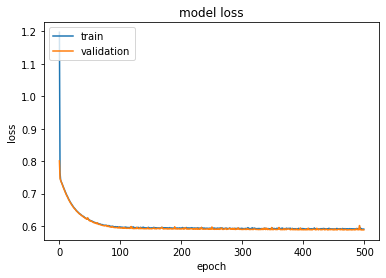

In [12]:
import matplotlib.pyplot as plt
print(history.history.keys())

### "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## This is a plot of the train vs. validation accuracy.

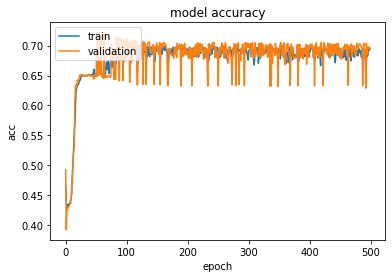

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predictions from the model

In [14]:
pred=model.predict(x1_test)

## AUC (or area under the curve) is used to assess the classifier accuracy.

### An AUC of 0.5 means that the model performs no better than random guessing. A value above 0.5 means that the model has predictive power.

AUC: 0.748


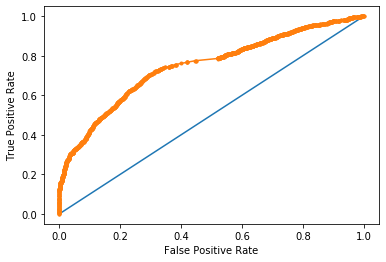

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

falsepos, truepos, thresholds = roc_curve(y1_test, pred)

auc = roc_auc_score(y1_test, pred)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y1_test, pred)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(falsepos, truepos, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()